<a href="https://colab.research.google.com/github/engineerJPark/FCN_Implementation/blob/main/FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

- take checker board calibration
- get distance and make extrinsic matrix

- validation IoU
- validation mAP

# model training and test

In [ ]:
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision.models import resnet18, ResNet18_Weights

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset


# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
from matplotlib import cm

import collections
import PIL
import os
import datetime


if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

torch.manual_seed(1)
if device == 'cuda:0':
    torch.cuda.manual_seed_all(1)

In [ ]:
print(torch.__version__)

1.12.1+cu113


In [ ]:
resnet_pretrained = resnet18(weights=ResNet18_Weights.DEFAULT)
# print(resnet_pretrained)

print('Turn Off the inplace operation')
print('.')
print('.')
print('.')

for name, child in resnet_pretrained.named_children():
    if isinstance(child, nn.ReLU):
        resnet_pretrained._modules[name] = nn.ReLU(inplace=False)
    elif isinstance(child, nn.Sequential):
        for sname, schild in child.named_children():
            for ssname, sschild in schild.named_children():
              if isinstance(sschild, nn.ReLU):
                  # print(name,sname,ssname)
                  resnet_pretrained._modules[name]._modules[sname]._modules[ssname] = nn.ReLU(inplace=False)

# print('--------------------------------')
# print('--------------------------------')
# print(resnet_pretrained)

print('Done.')

# torch.autograd.set_detect_anomaly(True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Turn Off the inplace operation
.
.
.
Done.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_DIR = '/content/gdrive/MyDrive/voc_data'

Mounted at /content/gdrive


In [ ]:
class VOCClassSegBase(torch.utils.data.Dataset):

    class_names = np.array([
        'background',
        'aeroplane',
        'bicycle',
        'bird',
        'boat',
        'bottle',
        'bus',
        'car',
        'cat',
        'chair',
        'cow',
        'diningtable',
        'dog',
        'horse',
        'motorbike',
        'person',
        'potted plant',
        'sheep',
        'sofa',
        'train',
        'tv/monitor',
    ])

    def __init__(self, root='/content/gdrive/MyDrive/voc_data', split='train', transform_tf=True):
        self.root = root
        self.split = split
        self.transform_tf = transform_tf
        self.transform = transforms.Compose([
            transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST),
            transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        self.transform_lbl = transforms.Compose([
            transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST)
        ])

        dataset_dir = os.path.join(self.root, 'VOCdevkit/VOC2012')
        self.files = collections.defaultdict(list)
        for split in ['train', 'val']:
            imgsets_file = os.path.join(
                dataset_dir, 'ImageSets/Segmentation/%s.txt' % split)
            for did in open(imgsets_file):
                did = did.strip()
                img_file = os.path.join(dataset_dir, 'JPEGImages/%s.jpg' % did)
                lbl_file = os.path.join(
                    dataset_dir, 'SegmentationClass/%s.png' % did)
                self.files[split].append({
                    'img': img_file,
                    'lbl': lbl_file,
                })

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        # data file
        data_file = self.files[self.split][index]
        
        # load
        img_file = data_file['img']
        img = PIL.Image.open(img_file)
        img = torch.from_numpy(np.array(img)).to(torch.float)

        lbl_file = data_file['lbl']
        lbl = PIL.Image.open(lbl_file)
        lbl = torch.from_numpy(np.array(lbl)).to(torch.long)
        lbl = torch.unsqueeze(lbl, dim=0)

        # image preprocessing
        img = img.permute(2, 0, 1) # HWC -> CHW
        lbl[lbl == 255] = -1

        # image transform
        if self.transform_tf == True:
            return self.transform(img), self.transform_lbl(lbl)
        else:
            return img, lbl


train_data = VOCClassSegBase(root=ROOT_DIR, split='train', transform_tf=True)

train_data_loader = DataLoader(dataset=train_data, batch_size = 1, drop_last=True)

In [ ]:
# Bilinear weights deconvolution Algorithm
def bilinear_kernel_init(Cin, Cout, kernel_size):
  factor = (kernel_size + 1) // 2
  if kernel_size % 2 == 1:
    center = factor - 1
  else:
    center = factor - 0.5

  og = (torch.arange(kernel_size).reshape(-1,1), torch.arange(kernel_size).reshape(1,-1))
  filter = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)

  weight = torch.zeros((Cin, Cout, kernel_size, kernel_size))
  weight[range(Cin), range(Cout), :, :] = filter
  return weight.clone()

In [ ]:
class FCN18(nn.Module):
  def __init__(self, class_n): # class 20 + 1(bakcground)
    super().__init__()
    self.downsample1 = nn.Sequential( # 1/2 of the input
        resnet_pretrained.conv1,
        resnet_pretrained.bn1,
        resnet_pretrained.relu,
        resnet_pretrained.maxpool
    )
    self.downsample2 = resnet_pretrained.layer1 # 1/4 of the input
    self.downsample3 = resnet_pretrained.layer2 # 1/8 of the input, extract featuremap that through 1x1 conv
    self.downsample4 = resnet_pretrained.layer3 # 1/16 of the input, extract featuremap that through 1x1 conv
    self.downsample5 = resnet_pretrained.layer4 # 1/32 of the input, extract featuremap that through 1x1 conv

    self.fully_conv_pool3 = nn.Conv2d(128, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool3.weight)

    self.fully_conv_pool4 = nn.Conv2d(256, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool4.weight)

    self.fully_conv_pool5 = nn.Conv2d(512, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool5.weight)
    
    # stride s, padding s/2, kernelsize 2s -> 2 times upsampling for images
    self.upsample_make_16s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/16
    self.upsample_make_16s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))

    self.upsample_make_8s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/8
    self.upsample_make_8s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))
    
    self.upsample_to_score = nn.ConvTranspose2d(class_n, class_n, kernel_size=16, padding=4, stride=8) # to 1
    self.upsample_to_score.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 16))
    for param in self.upsample_to_score.parameters(): # freeze the last layer
      param.requires_grad = False


  def forward(self, x):

    x = self.downsample1(x)
    x = self.downsample2(x)
    x = self.downsample3(x)
    pool3_score = self.fully_conv_pool3(x)
    x = self.downsample4(x)
    pool4_score = self.fully_conv_pool4(x)
    x = self.downsample5(x)
    pool5_score = self.fully_conv_pool5(x)

    pool4_2x_conv7 = pool4_score + self.upsample_make_16s(pool5_score)
    pool3_2x_pool4_4x_conv7 = pool3_score + self.upsample_make_8s(pool4_2x_conv7) # error log occured
    out = self.upsample_to_score(pool3_2x_pool4_4x_conv7)

    return out

In [ ]:
# epochs = 10
epochs = 13
lr = 10e-4
weight_decay = 2e-4
momentum = 0.9
batch_size = 64

model = FCN18(21)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

In [ ]:
test_model = FCN18(21)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
optimizer = optimizer

############################################################ fix this path
PATH = '/content/gdrive/MyDrive/fcn_model/model_8_14_8_19_46' # need to be fixed everytime

checkpoint = torch.load(PATH)
test_model.load_state_dict(checkpoint['model_state_dict']) 
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

test_model.train()
print('train mode start')

train mode start


In [ ]:
# train code
def train(model, epochs, optimizer, criterion):
  # with torch.autograd.detect_anomaly():
  for epoch in range(epochs):
    running_loss = 0
    for iter, (train_img, train_gt_img) in enumerate(train_data_loader):
      
      train_img = train_img.to(device)
      train_gt_img = train_gt_img.squeeze(dim=1).to(device)

      score_img = model(train_img)
      score_img = score_img.permute(0,2,3,1).reshape(-1, score_img.shape[1])
      train_gt_img = train_gt_img.reshape(-1, )

      loss = criterion(score_img, train_gt_img)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print("epoch %d, iteration: %d, loss : %f "%(epoch + 1, iter + 1, loss))

      running_loss += loss
    
    print('======================================')
    print("epoch %d, loss : %f "%(epoch + 1, running_loss / len(train_data_loader)))

    now = datetime.datetime.now()
    EPOCH = epoch
    PATH = "/content/gdrive/MyDrive/fcn_model/model_%d_%d_%d_%d_%d" % (now.month, now.day, now.hour, now.minute, now.second)
    LOSS = running_loss

    torch.save({
                'epoch': EPOCH,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': LOSS,
                }, PATH)
  
  print("Training End")

train(model, epochs, optimizer, criterion)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
epoch 10, iteration: 866, loss : 0.055489 
epoch 10, iteration: 867, loss : 0.069883 
epoch 10, iteration: 868, loss : 0.194558 
epoch 10, iteration: 869, loss : 0.004105 
epoch 10, iteration: 870, loss : 0.020651 
epoch 10, iteration: 871, loss : 0.013086 
epoch 10, iteration: 872, loss : 0.026082 
epoch 10, iteration: 873, loss : 0.052662 
epoch 10, iteration: 874, loss : 0.038897 
epoch 10, iteration: 875, loss : 0.027507 
epoch 10, iteration: 876, loss : 0.015090 
epoch 10, iteration: 877, loss : 0.052751 
epoch 10, iteration: 878, loss : 0.024596 
epoch 10, iteration: 879, loss : 0.022488 
epoch 10, iteration: 880, loss : 0.012350 
epoch 10, iteration: 881, loss : 0.031657 
epoch 10, iteration: 882, loss : 0.023698 
epoch 10, iteration: 883, loss : 0.064322 
epoch 10, iteration: 884, loss : 0.005046 
epoch 10, iteration: 885, loss : 0.015884 
epoch 10, iteration: 886, loss : 0.060437 
epoch 10, iteration: 887, loss : 0.028207 
epoch 10, iteratio

## Test

In [ ]:
test_model = FCN18(21)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

############################################################ fix this path
PATH = '/content/gdrive/MyDrive/fcn_model/model_8_14_14_14_25' # need to be fixed

checkpoint = torch.load(PATH)
test_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

test_model.eval()
print('model evaluation start')

model evaluation start


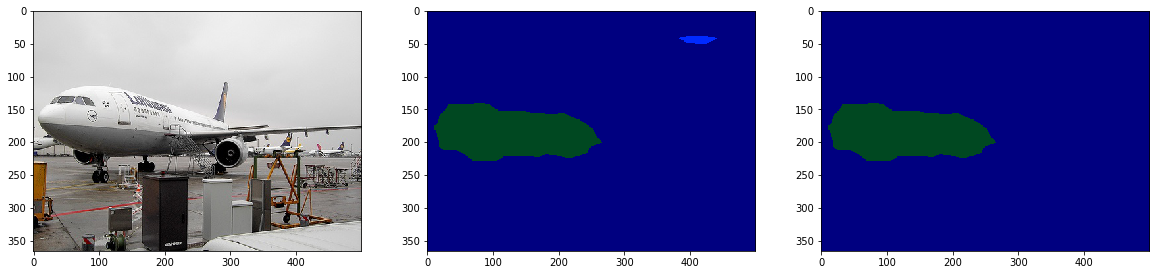

In [ ]:
# segmentation : plot image
with open(os.path.join(ROOT_DIR, "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"), 'r') as f:
  lines = f.readlines()
for i in range(len(lines)):
  lines[i] =  lines[i].strip('\n')
test_jpg = lines[0] + '.jpg'
test_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "JPEGImages", test_jpg))

# test image showing
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.imshow(test_image)

# test image transform & input to test model
test_image = np.array(test_image)
test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1)
ori_x, ori_y = test_image.shape[1], test_image.shape[2]

test_image = torch.unsqueeze(test_image, dim=0)

test_transform = transforms.Compose([
    transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST),
    transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
return_transform = transforms.Compose([
    transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.NEAREST),
])

test_seg = test_model(
    test_transform(test_image)
    )
test_seg = return_transform(test_seg)
test_seg[test_seg <= 8] = 0 # Thresholding

# model prediction
test_image_channel_idx = torch.argmax(torch.squeeze(test_seg, dim=0), dim=0)

# print(test_image_channel_idx[30, 75])

# model prediction to PIL
test_image_PIL = PIL.Image.fromarray(
    np.uint8(cm.gist_ncar(test_image_channel_idx.detach().numpy()*10)*255)
    )

# predicted data showing
plt.subplot(1,3,2)
plt.imshow(test_image_PIL)

# model prediction for only one class
test_image_channel_idx_copy = copy.deepcopy(test_image_channel_idx)
finding_class = 1 # editable
test_image_channel_idx_copy[test_image_channel_idx_copy != finding_class] = 0

# to PIL
test_image_PIL = PIL.Image.fromarray(
    np.uint8(cm.gist_ncar(test_image_channel_idx_copy.detach().numpy()*10)*255)
    )

# predicted data showing
plt.subplot(1,3,3)
plt.imshow(test_image_PIL)
plt.show()

In [ ]:
# validation IoU mAP



In [ ]:
# validation mAP



# codes for inference in other computer



In [ ]:
!pip --version
!sudo pip3 install open3d==0.13.0

import numpy as np
import math
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

import PIL
import os
import cv2

import open3d.camera.PinholeCameraIntrinsic as PinholeCameraIntrinsic
import open3d.camera.PinholeCameraParameters as PinholeCameraParameters
import open3d.geometry.PointCloud as PointCloud
import open3d.utility.Vector3dVector as Vector3dVector

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

torch.manual_seed(1)
if device == 'cuda:0':
    torch.cuda.manual_seed_all(1)

ModuleNotFoundError: ignored

In [ ]:
# a = torch.randn(4, 4)
# print(a)
# torch.max(a, 0)[0][0]

# np.array((np.array([1]), np.array([1]), 1))

# a = np.array([1,1,1])
# b = np.array([1,1,1])
# c = np.array([1,1,1])

# np.stack((a, b, c), axis=1)

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

In [ ]:
# camera Calibration

class predict_coord():
  '''
  HOW TO USE ???
  1. initialize with model
  2. take camera calibration
  3. get_cp_and_gw_on_point_cloud
  '''

  def __init__(self, model):
    self.model = model

  def calibrate_camera(self):
    '''
    need to be calculated
    color 기준 혹은 depth 기준따라 달라져야한다.
    https://www.intel.com/content/www/us/en/support/articles/000030385/emerging-technologies/intel-realsense-technology.html
    https://stackoverflow.com/questions/39992968/how-to-calculate-field-of-view-of-the-camera-from-camera-intrinsic-matrix
    https://www.intel.com/content/dam/support/us/en/documents/emerging-technologies/intel-realsense-technology/Intel-RealSense-D400-Series-Datasheet.pdf
    '''
    # intrinsic
    fov_x, fov_y = 69.4, 42.5
    width, height = 1920., 1080.
    fx, fy = width / (2 * math.tan(fov_x / 2)), width / (2 * math.tan(fov_y / 2))
    cx, cy = width // 2, height // 2 # need to be fixed if so

    # extrinsic. should be orthonormal
    rx1, rx2, rx3 = 0., 0., 0. # unit vector from robot frame (world coordinate)
    ry1, ry2, ry3 = 0., 0., 0.
    rz1, rz2, rz3 = 0., 0., 0.
    c1, c2, c3 = 0., 0., 0. # robot to camera distance
    
    t1 = -1 * (rx1 * c1 + rx2 * c2 + rx3 * c3)
    t2 = -1 * (ry1 * c1 + ry2 * c2 + ry3 * c3)
    t3 = -1 * (rz1 * c1 + rz2 * c2 + rz3 * c3)

    self.cam_intrinsic = PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)
    self.cam_intrinsic.intrinsic_matrix = np.array([[fx, 0, cx], 
                                                    [0, fy, cy], 
                                                    [0, 0, 1]])

    self.cam = PinholeCameraParameters()
    self.cam.intrinsic = self.cam_intrinsic
    self.cam.extrinsic = np.array([[rx1, rx2, rx3, t1], 
                                   [ry1, ry2, ry3, t2], 
                                   [rz1, rz2, rz3, t3], 
                                   [0., 0., 0., 1.]])
    
    self.cam_extrinsic_mat_inverse = np.linalg.inv(self.cam.extrinsic)
    self.cam_projection_mat = np.matmul(self.cam.intrinsic.intrinsic_matrix, self.cam.extrinsic) # ~u = P  x_world
    self.cam_projection_mat_inverse = np.linalg.inv(self.cam_projection_mat)

    # pcd = o3d.geometry.create_point_cloud_from_rgbd_image(rgbd_image, cam.intrinsic, cam.extrinsic)

  def img_to_world(self, img_xyz, s_depth : float):
    '''
    네가 쓸 것 아니다
    transform pixel image data to world coordinate
    xyz = [u v 1]
    s_depth = scaling factor, depth from camera to image
    s_depth * [u v 1] = self.cam_projection_mat * [xw yw zw 1]
    '''
    world_xyz = s_depth * np.matmul(self.cam_projection_mat_inverse, img_xyz)
    return world_xyz # numpy


  def camera_to_world(self, cam_xyz):
    '''
    네가 쓸 것 아니다
    transform camera image data to world coordinate
    '''
    world_xyz = np.matmul(self.cam_extrinsic_mat_inverse, cam_xyz)
    return world_xyz # numpy


  def image_xyz_to_open3d(self, xyz, s_depth=1., ref='image'):
      '''
      네가 쓸 것 아니다
      xyz : numpy array of xyz tuples/lists : N of points X xyz Dimension
      '''
      if ref == 'image':
        for i in range(len(xyz)):
          xyz[i] = self.img_to_world(xyz[i], s_depth)
      elif ref == 'cam':
        for i in range(len(xyz)):
          xyz[i] = self.camera_to_world(xyz[i])
      else:
        pass

      # Check empty
      open3d_cloud = PointCloud()
      if len(xyz) == 0:
          print("Converting an empty cloud")
          return None

      open3d_cloud.points = Vector3dVector(xyz)
      return open3d_cloud # open3d


  def get_cp_and_gw_on_point_cloud(self, pixel_img : PIL.Image, finding_class, s_depth=1.): 
    '''
    네가 쓸 것 맞다
    get center point of object(CP) and grasping width(GW) by fcn model
    안되면 point cloud로 전체 pixel을 옮겨서 cp와 width를 표시
    '''
    # test image transform & input to test model
    pixel_img = np.array(pixel_img)
    pixel_img = torch.from_numpy(pixel_img).to(torch.float).permute(2,0,1)
    ori_x, ori_y = pixel_img.shape[1], pixel_img.shape[2]

    pixel_img = torch.unsqueeze(pixel_img, dim=0)

    test_transform = transforms.Compose([
        transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST),
        transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return_transform = transforms.Compose([
        transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.NEAREST),
    ])

    # model prediction
    test_seg = self.model(
        test_transform(pixel_img)
        )
    test_seg = return_transform(test_seg)
    test_seg[test_seg <= 8] = 0 # Thresholding
    test_seg_idx = torch.argmax(torch.squeeze(test_seg, dim=0), dim=0)

    # point cloud calculation
    test_seg_idx_yx = (test_seg_idx == finding_class).nonzero(as_tuple=False)
    test_seg_idx_yx_aug = torch.ones((test_seg_idx_yx.shape[0], test_seg_idx_yx.shape[1] + 1))
    test_seg_idx_yx_aug[:, :-1] = test_seg_idx_yx
    test_seg_idx_yx_aug = test_seg_idx_yx_aug.numpy()

    seg2point_cloud = self.image_xyz_to_open3d(test_seg_idx_yx_aug, s_depth=s_depth, ref='image') # need to be return, open3d PointCloud

    for i in range(len(test_seg_idx_yx_aug)):
      test_seg_idx_yx_aug[i] = self.img_to_world(test_seg_idx_yx_aug[i], s_depth)

    test_max_x = np.max(test_seg_idx_yx_aug, axis=0)[1] # np.int
    test_min_x = np.min(test_seg_idx_yx_aug, axis=0)[1]
    test_max_y = np.max(test_seg_idx_yx_aug, axis=0)[0]
    test_min_y = np.min(test_seg_idx_yx_aug, axis=0)[0]

    # image plane coordinates (not normal)
    cp = np.array(((test_max_y + test_min_y) / 2, (test_max_x + test_min_x) / 2, 1))
    width = test_max_x - test_min_x
    left_side = np.array((cp[0] - width / 2, cp[1], 1))
    right_side = np.array((cp[0] + width / 2, cp[1], 1))

    cp_and_side_point_cloud = PointCloud()
    cp_and_side_point_cloud.points = Vector3dVector(np.stack((cp, left_side, right_side), axis=1)) # dimension 확인할 것

    return seg2point_cloud, cp_and_side_point_cloud

In [ ]:
class FCN18(nn.Module):
  def __init__(self, class_n): # class 20 + 1(bakcground)
    super().__init__()
    self.downsample1 = nn.Sequential( # 1/2 of the input
        resnet_pretrained.conv1,
        resnet_pretrained.bn1,
        resnet_pretrained.relu,
        resnet_pretrained.maxpool
    )
    self.downsample2 = resnet_pretrained.layer1 # 1/4 of the input
    self.downsample3 = resnet_pretrained.layer2 # 1/8 of the input, extract featuremap that through 1x1 conv
    self.downsample4 = resnet_pretrained.layer3 # 1/16 of the input, extract featuremap that through 1x1 conv
    self.downsample5 = resnet_pretrained.layer4 # 1/32 of the input, extract featuremap that through 1x1 conv

    self.fully_conv_pool3 = nn.Conv2d(128, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool3.weight)

    self.fully_conv_pool4 = nn.Conv2d(256, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool4.weight)

    self.fully_conv_pool5 = nn.Conv2d(512, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool5.weight)
    
    # stride s, padding s/2, kernelsize 2s -> 2 times upsampling for images
    self.upsample_make_16s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/16
    self.upsample_make_16s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))

    self.upsample_make_8s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/8
    self.upsample_make_8s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))
    
    self.upsample_to_score = nn.ConvTranspose2d(class_n, class_n, kernel_size=16, padding=4, stride=8) # to 1
    self.upsample_to_score.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 16))
    for param in self.upsample_to_score.parameters(): # freeze the last layer
      param.requires_grad = False


  def forward(self, x):

    x = self.downsample1(x)
    x = self.downsample2(x)
    x = self.downsample3(x)
    pool3_score = self.fully_conv_pool3(x)
    x = self.downsample4(x)
    pool4_score = self.fully_conv_pool4(x)
    x = self.downsample5(x)
    pool5_score = self.fully_conv_pool5(x)

    pool4_2x_conv7 = pool4_score + self.upsample_make_16s(pool5_score)
    pool3_2x_pool4_4x_conv7 = pool3_score + self.upsample_make_8s(pool4_2x_conv7) # error log occured
    out = self.upsample_to_score(pool3_2x_pool4_4x_conv7)

    return out

# test_model = FCN18(21)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

# ############################################################ fix this path
# PATH = '/content/gdrive/MyDrive/fcn_model/model_%d' % (epochs)

# checkpoint = torch.load(PATH)
# test_model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# test_model.eval()
# print('model evaluation start')

In [ ]:
class predictor():
  def __init__(self, path:str):
    PATH = path
    self.model = FCN18(21)
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    checkpoint = torch.load(PATH)
    self.model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # epoch = checkpoint['epoch']
    # loss = checkpoint['loss']

    self.model.eval()
    print('model evaluation start')

  def predict_pointcloud(self, image):
    '''
    image : PIL format, gonna be numpy array
    '''

    # # segmentation : plot image
    # with open(os.path.join(ROOT_DIR, "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"), 'r') as f:
    #   lines = f.readlines()
    # for i in range(len(lines)):
    #   lines[i] =  lines[i].strip('\n')
    # test_jpg = lines[0] + '.jpg'
    # test_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "JPEGImages", test_jpg))

    # image_np = np.array(image)
    image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_torch = torch.from_numpy(image_np).to(torch.float).permute(2,0,1)
    ori_x, ori_y = image_torch.shape[1], image_torch.shape[2]

    image_torch = torch.unsqueeze(image_torch, dim=0)

    test_transform = transforms.Compose([
        transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST),
        transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return_transform = transforms.Compose([
        transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.NEAREST),
    ])

    test_seg = self.model(test_transform(image_torch))
    test_seg = return_transform(test_seg)
    test_seg[test_seg <= 8] = 0 # Thresholding

    test_image_channel_idx = torch.argmax(torch.squeeze(test_seg, dim=0), dim=0) # final prediction

    # test_image_PIL = PIL.Image.fromarray(
    #     np.uint8(cm.gist_ncar(test_image_channel_idx.detach().numpy()*10)*255)
    #     )

    test_image_mask = np.uint8(cm.gist_ncar(test_image_channel_idx.detach().numpy()*10)*255)    
    
    plt.figure(figsize=(10, 20))
    plt.subplot(1,2,1)
    plt.imshow(image)

    plt.subplot(1,2,2)
    plt.imshow(test_image_mask)
    plt.show()

In [ ]:
iter = 1
filename = "rs_image_%d" % (iter)
cv2.imwrite(filename, img)
iter += 1

In [ ]:
print(point_cloud)
print(point_cloud.points)

# code for renaming

In [ ]:
# rename image and ground truth files

import os
from google.colab import drive

drive.mount('/content/gdrive')
ROOT_DIR = '/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT'

# 주어진 디렉토리에 있는 항목들의 이름을 담고 있는 리스트를 반환합니다.
# 리스트는 임의의 순서대로 나열됩니다.
file_path1 = os.path.join(ROOT_DIR, 'real_world_data/rgb')
file_names1 = os.listdir(file_path1)
file_names1.sort()
print(file_names1)

i = 1
for name in file_names1:
    src = os.path.join(file_path1, name)
    dst = 'rs_image_' + str(i) + '.jpg'
    dst = os.path.join(file_path1, dst)
    os.rename(src, dst)
    i += 1

file_path2 = os.path.join(ROOT_DIR, 'real_world_data/gt')
file_names2 = os.listdir(file_path2)
file_names2.sort()
print(file_names2)

i = 1
for name in file_names2:
    src = os.path.join(file_path2, name)
    dst = 'rs_gt_' + str(i) + '.png'
    dst = os.path.join(file_path2, dst)
    os.rename(src, dst)
    i += 1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['rs_image_100_jpg.rf.6e592c36c2dda4cfc4725ba71833caff.jpg', 'rs_image_100_jpg.rf.b67f162e841ce26354b145eca904af85.jpg', 'rs_image_100_jpg.rf.f5f303606e3bb6e98e3a07c3e87b3174.jpg', 'rs_image_101_jpg.rf.0a3d044b408877350627b8977705afc5.jpg', 'rs_image_101_jpg.rf.0fc00442c16d79f2534525b9c2a264d4.jpg', 'rs_image_101_jpg.rf.7cfeb1d391ad8c9238938b26eca0c544.jpg', 'rs_image_104_jpg.rf.4d9998fb97f1f766ee5232529f8789e5.jpg', 'rs_image_104_jpg.rf.d66e7310574dea9a9cd8c2c730e7a6ec.jpg', 'rs_image_104_jpg.rf.e9ed363be95b8b66d548fba81a0fd9b9.jpg', 'rs_image_106_jpg.rf.a15b7dc623b91f884e2e67081c4fb30f.jpg', 'rs_image_106_jpg.rf.b7895ba90d3e21501696791bca35d29c.jpg', 'rs_image_106_jpg.rf.d729c3677444014602bba9655faaf28a.jpg', 'rs_image_107_jpg.rf.2d41687e186ffc79293fdfb715d80722.jpg', 'rs_image_107_jpg.rf.66d5cb393e9183d675beccf97b733366.jpg', 'rs_image_107_jpg.rf.abea7bd

# code for re-training

In [ ]:
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision.models import resnet18, ResNet18_Weights

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset


# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
from matplotlib import cm

import collections
import PIL
import os
import datetime


if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

torch.manual_seed(1)
if device == 'cuda:0':
    torch.cuda.manual_seed_all(1)

print(torch.__version__)

1.12.1+cu113


In [ ]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
ROOT_DIR = '/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT'

# dataset for new image

class VOCClassSegBase(torch.utils.data.Dataset):
  '''
  input size : (480, 640, 3) (480, 640)
  '''

  class_names = np.array([
      'background',
      'roll',
      'sauce',
      'snack',
  ])

  def __init__(self, root='/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT', split='train', transform_tf=True):
      self.root = root
      self.split = split
      self.transform_tf = transform_tf
      self.transform = transforms.Compose([ # interpolation=InterpolationMode.BILINEAR
          transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
          transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
      ])

      file_names_rgb = os.listdir(os.path.join(ROOT_DIR, 'real_world_data/rgb'))
      file_names_rgb.sort()

      DATASET_DIR = os.path.join(self.root, 'real_world_data')
      self.files = collections.defaultdict(list)
      for split in ['train', 'val']:
        for i in range(len(file_names_rgb)):
            img_file = os.path.join(DATASET_DIR, 'rgb/rs_image_%d.jpg' % (i + 1))
            lbl_file = os.path.join(DATASET_DIR, 'gt/rs_gt_%d.png' % (i + 1))
            self.files[split].append({
                'img': img_file,
                'lbl': lbl_file,
            })

  def __len__(self):
      return len(self.files[self.split])

  def __getitem__(self, index):
      # data file
      data_file = self.files[self.split][index]
      
      # load
      img_file = data_file['img']
      img = PIL.Image.open(img_file)
      img = torch.from_numpy(np.array(img)).to(torch.float)

      lbl_file = data_file['lbl']
      lbl = PIL.Image.open(lbl_file)
      lbl = torch.from_numpy(np.array(lbl)).to(torch.long)
      lbl = torch.unsqueeze(lbl, dim=0)

      # 반드시 확인해야할 것
      # image preprocessing
      img = img.permute(2, 0, 1) # HWC -> CHW 
      lbl[lbl == 255] = -1

      # image transform
      if self.transform_tf == True:
          return self.transform(img), lbl
      else:
          return img, lbl

train_data = VOCClassSegBase(root=ROOT_DIR, split='train', transform_tf=True)
train_data_loader = DataLoader(dataset=train_data, batch_size = 1, drop_last=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# resnet pretrained download
resnet_pretrained = resnet18(weights=ResNet18_Weights.DEFAULT)
# print(resnet_pretrained)

print('Turn Off the inplace operation')
print('.')
print('.')
print('.')

for name, child in resnet_pretrained.named_children():
    if isinstance(child, nn.ReLU):
        resnet_pretrained._modules[name] = nn.ReLU(inplace=False)
    elif isinstance(child, nn.Sequential):
        for sname, schild in child.named_children():
            for ssname, sschild in schild.named_children():
              if isinstance(sschild, nn.ReLU):
                  # print(name,sname,ssname)
                  resnet_pretrained._modules[name]._modules[sname]._modules[ssname] = nn.ReLU(inplace=False)

print('Done.')

# Bilinear weights deconvolution Algorithm
def bilinear_kernel_init(Cin, Cout, kernel_size):
  factor = (kernel_size + 1) // 2
  if kernel_size % 2 == 1:
    center = factor - 1
  else:
    center = factor - 0.5

  og = (torch.arange(kernel_size).reshape(-1,1), torch.arange(kernel_size).reshape(1,-1))
  filter = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)

  weight = torch.zeros((Cin, Cout, kernel_size, kernel_size))
  weight[range(Cin), range(Cout), :, :] = filter
  return weight.clone()

# FCN18 declaration
class FCN18(nn.Module):
  def __init__(self, class_n): # class 20 + 1(bakcground)
    super().__init__()
    self.downsample1 = nn.Sequential( # 1/2 of the input
        resnet_pretrained.conv1,
        resnet_pretrained.bn1,
        resnet_pretrained.relu,
        resnet_pretrained.maxpool
    )
    self.downsample2 = resnet_pretrained.layer1 # 1/4 of the input
    self.downsample3 = resnet_pretrained.layer2 # 1/8 of the input, extract featuremap that through 1x1 conv
    self.downsample4 = resnet_pretrained.layer3 # 1/16 of the input, extract featuremap that through 1x1 conv
    self.downsample5 = resnet_pretrained.layer4 # 1/32 of the input, extract featuremap that through 1x1 conv

    self.fully_conv_pool3 = nn.Conv2d(128, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool3.weight)

    self.fully_conv_pool4 = nn.Conv2d(256, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool4.weight)

    self.fully_conv_pool5 = nn.Conv2d(512, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool5.weight)
    
    # stride s, padding s/2, kernelsize 2s -> 2 times upsampling for images
    self.upsample_make_16s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/16
    self.upsample_make_16s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))

    self.upsample_make_8s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/8
    self.upsample_make_8s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))
    
    self.upsample_to_score = nn.ConvTranspose2d(class_n, class_n, kernel_size=16, padding=4, stride=8) # to 1
    self.upsample_to_score.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 16))
    for param in self.upsample_to_score.parameters(): # freeze the last layer
      param.requires_grad = False


  def forward(self, x):

    x = self.downsample1(x)
    x = self.downsample2(x)
    x = self.downsample3(x)
    pool3_score = self.fully_conv_pool3(x)
    x = self.downsample4(x)
    pool4_score = self.fully_conv_pool4(x)
    x = self.downsample5(x)
    pool5_score = self.fully_conv_pool5(x)

    pool4_2x_conv7 = pool4_score + self.upsample_make_16s(pool5_score)
    pool3_2x_pool4_4x_conv7 = pool3_score + self.upsample_make_8s(pool4_2x_conv7)
    out = self.upsample_to_score(pool3_2x_pool4_4x_conv7)

    return out

Turn Off the inplace operation
.
.
.
Done.


In [ ]:
import copy

epochs = 30
lr = 10e-4
weight_decay = 1e-8
momentum = 0.9
batch_size = 64

# data loading from the file
model = FCN18(4)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

############################################################ fix this path. need to be fixed everytime
PATH = '/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/fcn_model/21class_trained/model_10_21class'

checkpoint = torch.load(PATH)
state_dict = checkpoint['model_state_dict']
new_state_dict = collections.OrderedDict()

with torch.no_grad():
  for key in state_dict:
    if key.split('.')[0][:-1] == 'downsample':
      new_state_dict[key] = copy.deepcopy(state_dict[key])

model.load_state_dict(new_state_dict,strict=False) 
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.train()
print('train mode start')

# print(model) # 정 안되면 voc pretrained 말고 resnet pretrained만 사용해보자.
# https://discuss.pytorch.org/t/how-to-freeze-parts-of-the-net/84649/9

model.downsample1.requires_grad = False
model.downsample2.requires_grad = False
model.downsample3.requires_grad = False
model.downsample4.requires_grad = False
model.downsample5.requires_grad = False

train mode start


In [ ]:
# epochs = 30
# lr = 10e-4
# weight_decay = 1e-8
# momentum = 0.9
# batch_size = 64

# # data loading from the file
# model = FCN18(4)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# criterion = nn.CrossEntropyLoss(ignore_index=-1)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# ############################################################ fix this path
# PATH = '/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/fcn_model/model_8_15_9_4_33'

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.train()
# print('train mode start')

In [ ]:
# train code
def train(model, epochs, optimizer, criterion):
  # with torch.autograd.detect_anomaly():
  for epoch in range(epochs):
    running_loss = 0
    for iter, (train_img, train_gt_img) in enumerate(train_data_loader):
      
      train_img = train_img.to(device)
      train_gt_img = train_gt_img.squeeze(dim=1).to(device)

      score_img = model(train_img)
      score_img = score_img.permute(0,2,3,1).reshape(-1, score_img.shape[1])
      train_gt_img = train_gt_img.reshape(-1, )

      loss = criterion(score_img, train_gt_img)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print("epoch %d, iteration: %d, loss : %f "%(epoch + 1, iter + 1, loss))

      running_loss += loss
    
    print('======================================')
    print("epoch %d, loss : %f "%(epoch + 1, running_loss / len(train_data_loader)))

    now = datetime.datetime.now()
    EPOCH = epoch
    PATH = "/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/fcn_model/model_%d_%d_%d_%d_%d" % (now.month, now.day, now.hour, now.minute, now.second)
    LOSS = running_loss / len(train_data_loader)

    torch.save({
                'epoch': EPOCH,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': LOSS,
                }, PATH)
    scheduler.step()
  
  print("Training End")

train(model, epochs, optimizer, criterion)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
epoch 13, iteration: 114, loss : 0.050830 
epoch 13, iteration: 115, loss : 0.044800 
epoch 13, iteration: 116, loss : 0.035273 
epoch 13, iteration: 117, loss : 0.040294 
epoch 13, iteration: 118, loss : 0.038913 
epoch 13, iteration: 119, loss : 0.036586 
epoch 13, iteration: 120, loss : 0.027392 
epoch 13, iteration: 121, loss : 0.052160 
epoch 13, iteration: 122, loss : 0.044689 
epoch 13, iteration: 123, loss : 0.052632 
epoch 13, iteration: 124, loss : 0.035607 
epoch 13, iteration: 125, loss : 0.030860 
epoch 13, iteration: 126, loss : 0.031765 
epoch 13, iteration: 127, loss : 0.045076 
epoch 13, iteration: 128, loss : 0.059112 
epoch 13, iteration: 129, loss : 0.046009 
epoch 13, iteration: 130, loss : 0.037437 
epoch 13, iteration: 131, loss : 0.041376 
epoch 13, iteration: 132, loss : 0.057168 
epoch 13, iteration: 133, loss : 0.039511 
epoch 13, iteration: 134, loss : 0.055649 
epoch 13, iteration: 135, loss : 0.041251 
epoch 13, iteratio

## Test

In [ ]:
test_model = FCN18(4)

############################################################ fix this path
PATH = '/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/fcn_model/model_8_16_2_47_8'

checkpoint = torch.load(PATH)
test_model.load_state_dict(checkpoint['model_state_dict'])

test_model.eval()
print('model evaluation start')

model evaluation start


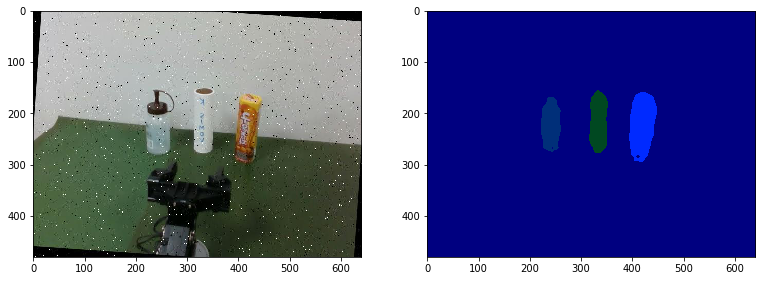

In [ ]:
# segmentation : plot image
test_image = PIL.Image.open('/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/real_world_data/rgb/rs_image_150.jpg')

# test image showing
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.imshow(test_image)

# test image transform & input to test model
test_image = np.array(test_image)
test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1)

test_image = torch.unsqueeze(test_image, dim=0)

test_transform = transforms.Compose([ # interpolation=InterpolationMode.BILINEAR
    transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_seg = test_model(test_transform(test_image))

# model prediction
test_image_channel_idx = torch.argmax(torch.squeeze(test_seg, dim=0), dim=0)

# print(test_image_channel_idx[30, 75])

# model prediction to PIL
test_image_PIL = PIL.Image.fromarray(
    np.uint8(cm.gist_ncar(test_image_channel_idx.detach().numpy()*10)*255)
    )

# predicted data showing
plt.subplot(1,3,2)
plt.imshow(test_image_PIL)
plt.show()

# # model prediction for only one class
# test_image_channel_idx_copy = copy.deepcopy(test_image_channel_idx)
# finding_class = 1 # editable
# test_image_channel_idx_copy[test_image_channel_idx_copy != finding_class] = 0
# print(test_image_channel_idx_copy[240, 320])

# # to PIL
# test_image_PIL_for_1class = PIL.Image.fromarray(
#     np.uint8(cm.gist_ncar(test_image_channel_idx_copy.detach().numpy()*10)*255)
#     )

# # predicted data showing
# plt.subplot(1,3,3)
# plt.imshow(test_image_PIL_for_1class)
# plt.show()

# Reference

# mAP and IoU implementation

- https://discuss.pytorch.org/t/iou-pytorch-implementation/21473
- https://pytorch.org/vision/stable/ops.html
- https://stackoverflow.com/questions/48260415/pytorch-how-to-compute-iou-jaccard-index-for-semantic-segmentation
- https://github.com/Cartucho/mAP
- https://github.com/sunnynevarekar/pytorch-saliency-maps



# camera calibration

- http://www.open3d.org/docs/release/python_api/open3d.camera.PinholeCameraIntrinsic.html

- https://velog.io/@openjr/ROS-Camera-Calibration

- https://pinkwink.kr/1353

- https://learnopencv.com/camera-calibration-using-opencv/

- https://darkpgmr.tistory.com/84
- https://darkpgmr.tistory.com/83
- https://darkpgmr.tistory.com/81
- https://darkpgmr.tistory.com/82
- https://darkpgmr.tistory.com/122?category=460965
- https://darkpgmr.tistory.com/32
- https://darkpgmr.tistory.com/122
- https://fpcv.cs.columbia.edu/

- https://pcl.gitbook.io/tutorial/
- https://github.com/felixchenfy/open3d_ros_pointcloud_conversion
- https://stackoverflow.com/questions/39992968/how-to-calculate-field-of-view-of-the-camera-from-camera-intrinsic-matrix

segmentation을 open3d로 보내준 뒤, open3d로 변환한 point cloud를 잘라준다.